In [2]:
import glob
import os
import numpy as np
import pandas as pd

import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location

import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import pytz #accurate and cross platform timezone calculations
#from pysolar import solar
import datetime
import math


In [3]:
tz = pytz.timezone("Asia/Manila")

In [4]:

#Calculate Solar Zenith Angle
'''def sza(a):
    lat = 14.63667
    lon = 121.07667
    elevation = 0

    toj = datetime.datetime(a['YY'],a['MM'],a['DD'],a['HH'],a['mm'],a['SS'],tzinfo=datetime.timezone.utc)
    #https://pysolar.readthedocs.io/en/latest/
    sza = 90 - solar.get_altitude(lat,lon,toj,elevation)
    return(sza)
'''
#Calculate Cosine of Solar Zenith Angle
def cossza(a):
    cos_sza = math.cos(math.radians(a['sza']))
    return(cos_sza)

#Calculate Direct Normal Irradiance
def dni(a):
    cos_sza = math.cos(math.radians(a['sza']))
    dni = (a['SPN1_Total_Solar'] - a['SPN1_Diff_Solar']) / cos_sza
    return(dni)

In [5]:
#Part 1: Retaining GHI values that passed Test 1 to 3
#sigma_lim = 1.2
diffuse_solar_lim = 150

def flag_clear(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000) \
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            flag_clear = 'Y'
            
        else:
            flag_clear = 'N'

            
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)\
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            flag_clear = 'Y'
            
        else:
            flag_clear = 'N'

    return(flag_clear)

def test_ghi(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000) \
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_ghi = a['SPN1_Total_Solar']
            
        else:
            t1_ghi = np.nan

            
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)\
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_ghi = a['SPN1_Total_Solar']

        else: 
            t1_ghi = np.nan

    return(t1_ghi)

#Part 2: Retaining DHI Values that passed Test 1 & 2
def test_dhi(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000)
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_dhi = a['SPN1_Diff_Solar']  
            
        else:
            t1_dhi = np.nan
                     
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_dhi = a['SPN1_Diff_Solar'] 
            
        else: 
            t1_dhi = np.nan
           
    return(t1_dhi)


#Part 4: (for Plotting) Imposed Limits for Test 1
def lim(a):
    if (a['sza'] < 78.5):
        lim = 1000
    elif (a['sza'] >= 78.5):
        lim = 900
    return(lim)




In [8]:
path = 'processed/' # use your path
all_files = glob.glob(os.path.join(path, "*10min*.csv"))
a = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

a['Time'] = pd.to_datetime(a['Time'])


'''a = a[a['SPN1_Total_Solar'] >= 0]
a = a.set_index('Time')
a['YY'] = pd.DatetimeIndex(a.index).year
a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute
a['SS'] = pd.DatetimeIndex(a.index).second
a['YY'] = a['YY'].astype(int)
a['MM'] = a['MM'].astype(int)
a['DD'] = a['DD'].astype(int)
a['HH'] = a['HH'].astype(int)
a['mm'] = a['mm'].astype(int)
a['SS'] = a['SS']'''

a['dhi'] = a['SPN1_Diff_Solar']
a['ghi_a'] = a['SPN1_Total_Solar']

'''a['YY'] = pd.DatetimeIndex(a.index).year
a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute
a['SS'] = pd.DatetimeIndex(a.index).second
a['YY'] = a['YY'].astype(int)
a['MM'] = a['MM'].astype(int)
a['DD'] = a['DD'].astype(int)
a['HH'] = a['HH'].astype(int)
a['mm'] = a['mm'].astype(int)
a['SS'] = a['SS'].astype(int)

a= a.reset_index()'''


# Calculate the clear sky estimates of GHI, DNI, and/or DHI at this location
# Ineichen-Perez Clear Sky model 
tus = Location(14.6361, 121.0775, 'Asia/Manila', 100, 'Manila')
times = pd.date_range(start='2020-01-01', end='2020-12-31', freq='10min', tz=tus.tz)

#https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html
cs = tus.get_clearsky(times).reset_index()
cs['Time'] = pd.to_datetime(cs['index']).dt.tz_convert('utc')

#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html#pvlib.solarposition.get_solarposition
cs2 = tus.get_solarposition(times).reset_index()
cs2['Time'] = pd.to_datetime(cs2['index']).dt.tz_convert('utc')

cs2['sza'] = cs2['apparent_zenith']
cs = cs.merge(cs2, how='inner', on='Time')
cs = cs[[ 'Time', 'ghi', 'dni', 'dhi', 'sza']]

cs['GHI_in'] = cs['ghi']
cs['DNI_in'] = cs['dni']
cs['DHI_in'] = cs['dhi']
cs = cs[['Time', 'GHI_in', 'DNI_in', 'DHI_in', 'sza']]

a = a.merge(cs, how='inner', on='Time')

#Calculate Cosine of Solar Zenith Angle
a["cossza"] = a.apply(cossza, axis=1)
#Calculate Direct Normal Irradiance
a["dni"] = a.apply(dni, axis=1)

#Remove timesteps when solar zenith angle is greater than 90 (nighttime values)
a = a[a['sza']<= 90]

a = a[['Time', 'SPN1_Total_Solar', 'SPN1_Diff_Solar','CGR4_IR', \
       'dhi', 'ghi_a', 'sza', 'cossza', 'dni']]

#Prepare Local Time for plots & clear sky calculation
a['LST'] = a['Time'].dt.tz_convert(tz)

a = a.set_index('LST')

a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute



In [9]:
#Clear Sky Test 1: Normalized Total Shortwave Magnitude Test (Long and Ackerman 2000)
#Equation 2
a["cossza_b"] = (a['cossza'])**1.31
#Normalized Total Shortwave
a['SPN1_Total_Solar_N'] = a['SPN1_Total_Solar']/a["cossza_b"]

#Clear Sky Test 2: Diffuse Shortwave Magnitude Test (Long and Ackerman 2000)
#Equation 3
a['t2_lim'] = diffuse_solar_lim*((a['cossza'])**0.5)

In [10]:

#Clear Sky Test 1 - 2: 
#Normalized Total Shortwave Magnitude Test 
#Max Diffuse Shortwave Test
#retains clear-sky periods only
#for plotting
a['ghi_cc_val'] = a.apply(test_ghi, axis=1)
a['dhi_cc_val'] = a.apply(test_dhi, axis=1)
a['t1_lim'] = a.apply(lim, axis=1)
a['flag_clear'] = a.apply(flag_clear, axis=1)


a.to_csv('with_flags.csv')

In [12]:
a = a[['Time', 'SPN1_Total_Solar', 'SPN1_Diff_Solar',
       'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni', 'MM', 'DD', 'HH', 'mm',
       'cossza_b', 
       'SPN1_Total_Solar_N',
       'ghi_cc_val', 'dhi_cc_val', 't1_lim','t2_lim']]

In [13]:
# Calculate the clear sky estimates of GHI, DNI, and/or DHI at this location
# Ineichen=Perez Clear Sky model 

b = cs.merge(a, how='outer', on='Time')

#Prepare Local Time for plots & clear sky calculation
b['LST'] = b['Time'].dt.tz_convert(tz)

b = b.set_index('LST')
b['YY'] = pd.DatetimeIndex(b.index).year
b['MM'] = pd.DatetimeIndex(b.index).month
b['DD'] = pd.DatetimeIndex(b.index).day
b['HH'] = pd.DatetimeIndex(b.index).hour
b['mm'] = pd.DatetimeIndex(b.index).minute
b = b.reset_index()

b= b[b['GHI_in'] > 0 ]


In [14]:
b.columns

Index(['LST', 'Time', 'GHI_in', 'DNI_in', 'DHI_in', 'sza_x',
       'SPN1_Total_Solar', 'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a',
       'sza_y', 'cossza', 'dni', 'MM', 'DD', 'HH', 'mm', 'cossza_b',
       'SPN1_Total_Solar_N', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 't2_lim',
       'YY'],
      dtype='object')

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2988800896.py:70: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_v1timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


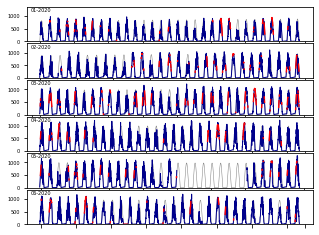

In [16]:
'''
subplot where each row is one month
y-axis 0-1400
x-axis 600 to 1900 LST
plot limits for clear-sky cases as per test 1
a) normalized total shortwave FN 
b) measured total shortwave and diffuse shortwave
'''
sigma_lim = 'no'

dir_path_recursive = f'img/long_ackerman_test/{sigma_lim}_sigma'
os.makedirs(dir_path_recursive, exist_ok=True)



fig = plt.figure()
gs = fig.add_gridspec(18, 7)
    
  
for m in np.arange(1, 7, 1):
        
    sb = b[(b['MM']==m) ]
    
    #sb['SPN1_Total_Solar'] = sb['SPN1_Total_Solar'].replace(np.nan,0)
    #sb['t1_cc_val'] = sb['t1_cc_val'].replace(0,np.nan)
    if (m==1):
        i = 0

    if (m==2):
        i = 3

    if (m==3):
        i = 6

    if (m==4):
        i = 9

    if (m==5):
        i = 12
        sb.to_csv('sample.csv')
    if (m==6):
        i = 15


    ax00 = fig.add_subplot(gs[i:i+3, 0:6])
    plt.text(0.05, 0.9, f'{m:02}-2020', fontsize=5,horizontalalignment='center', verticalalignment='center', transform=ax00.transAxes)

    ax00.plot(sb.Time,sb['GHI_in'],c='gray',linewidth=0.5)
    #x3 = np.ma.masked_where(sb['SPN1_Total_Solar'] == np.nan, sb.Time)
    #y3 = np.ma.masked_where(sb['SPN1_Total_Solar'] == np.nan, sb['GHI_in'])
    #plt.plot(x3,y3,c='gray',linewidth=1.)
    ax00.plot(sb.Time,sb['SPN1_Total_Solar'],c='DarkBlue',linewidth=1.)
    
    
    ax00.plot(sb.Time,sb['ghi_cc_val'],c='red',linewidth=1.4)
    #plt.plot(sb.Time,sb['t1_cc_val'], marker='o', markersize=1, linewidth=0.5,color='red')
    
    

    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.xaxis.set_major_formatter(md.DateFormatter('%d'))
    ax00.set_xticklabels([])
    #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
    
#ax00.set_ylabel('Total\nShortwave (W/m$^2$)',fontsize= 5)
#ax00.set_xlabel('Month-Day',fontsize= 5)


plt.savefig(f'{dir_path_recursive}/{sigma_lim}_v1timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")



/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/3501644520.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_v2timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


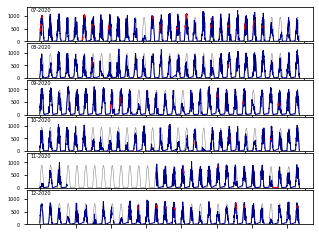

In [17]:
'''
subplot where each row is one month
y-axis 0-1400
x-axis 600 to 1900 LST
plot limits for clear-sky cases as per test 1
a) normalized total shortwave FN 
b) measured total shortwave and diffuse shortwave
'''

fig = plt.figure()
gs = fig.add_gridspec(18, 7)
    
    
for m in np.arange(7, 13, 1):
        
    sb = b[(b['MM']==m) & (b['YY']==2020)]
    #sb['SPN1_Total_Solar'] = sb['SPN1_Total_Solar'].replace(0,np.nan)
    #sb['t1_cc_val'] = sb['t1_cc_val'].replace(0,np.nan)
    if (m==7):
        i = 0

    if (m==8):
        i = 3

    if (m==9):
        i = 6

    if (m==10):
        i = 9

    if (m==11):
        i = 12

    if (m==12):
        i = 15
        sb.to_csv('sample.csv')
    ax00 = fig.add_subplot(gs[i:i+3, 0:6])
    plt.text(0.05, 0.9, f'{m:02}-2020', fontsize=5,horizontalalignment='center', verticalalignment='center', transform=ax00.transAxes)
    ax00.plot(sb.Time,sb['GHI_in'],c='gray',linewidth=0.5)    
    ax00.plot(sb.Time,sb['SPN1_Total_Solar'],c='DarkBlue',linewidth=1.)
    #plt.plot(sb.Time, sb['SPN1_Total_Solar'], marker='o', markersize=1, linewidth=0.5,color='DarkBlue')
    
    ax00.plot(sb.Time,sb['ghi_cc_val'],c='red',linewidth=1.4)
    #plt.plot(sb.Time,sb['t1_cc_val'], marker='o', markersize=1, linewidth=0.5,color='red')
    
    
    
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.xaxis.set_major_formatter(md.DateFormatter('%d'))
    ax00.set_xticklabels([])
    #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
    
#ax00.set_ylabel('Total\nShortwave (W/m$^2$)',fontsize= 5)
#ax00.set_xlabel('Month-Day',fontsize= 5)


plt.savefig(f'{dir_path_recursive}/{sigma_lim}_v2timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")



In [ ]:
'''
plot per day 
y-axis 0-1400
x-axis 600 to 1900 LST
plot limits for clear-sky cases as per test 1
a) normalized total shortwave FN 
b) measured total shortwave and diffuse shortwave
'''

#for m in np.arange(3, 4, 1):
for m in np.arange(1, 13, 1):

    if m in [1, 3, 5, 7, 8, 10, 12]:
        dmax = 32
    elif m in [2]:
        dmax = 30
    else:
        dmax = 31
    
    #for day in np.arange(25, dmax, 1):
    for day in np.arange(1, dmax, 1):
        try:
            sb = b[(b['MM']==m) & (b['DD']==day)]
            sb.to_csv('sample.csv')
            
            
            
            
            fig = plt.figure()
            
            gs = fig.add_gridspec(2, 5)


            ax1 = fig.add_subplot(gs[0, 0:2])
            plt.text(0.5, 1.1, f'{m:02}-{day:02}-2020', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
            ax1.plot(sb.LST,sb['SPN1_Total_Solar_N'],c='DarkBlue')
            ax1.plot(sb.LST,sb['t1_lim'],c='r',linewidth=1.)
            plt.axhline(y = 1250, color = 'r', linestyle = '-',linewidth=1)
            #plt.hlines(y=horiz_line, xmin=0, xmax=max(x_data), color='red', zorder=1)
            ax1.tick_params(axis='both', which='major', labelsize=5)
            ax1.set_ylim(0,1450)
            ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
            ax1.set_xticklabels([])
            ax1.set_ylabel('Normalized Total\nShortwave (W/m$^2$)',fontsize= 5)


            ax00 = fig.add_subplot(gs[1, 0:2])
            ax00.plot(sb.LST,sb['SPN1_Total_Solar'],c='k',linewidth=1.5)
            ax00.plot(sb.LST,sb['SPN1_Diff_Solar'],c='k',linewidth=0.5)
            ax00.plot(sb.LST,sb['ghi_cc_val'],c='red',linewidth=1.5)
            ax00.plot(sb.LST,sb['GHI_in'],c='orange',linewidth=0.15)
            ax00.plot(sb.LST,sb['dhi_cc_val'],c='red',linewidth=0.6)
            #ax00.plot(sb.Time,sb['DHI_in'],c='orange',linewidth=0.15)
            ax00.tick_params(axis='both', which='major', labelsize=5)
            ax00.set_ylim(0,1360)
            ax00.xaxis.set_major_formatter(md.DateFormatter('%H'))
            #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
            ax00.set_ylabel('Measured\nShortwave (W/m$^2$)',fontsize= 5)
            ax00.set_xlabel('Hour (UTC)',fontsize= 5)
            
            ax1 = fig.add_subplot(gs[0, 3:5])
            ax1.plot(sb['cossza'],sb['SPN1_Diff_Solar'],c='k',linewidth=0.5)
            ax1.plot(sb['cossza'],sb['t2_lim'],c='r',linewidth=0.5)
            ax1.tick_params(axis='both', which='major', labelsize=5)
            #ax1.set_ylim(0,160)
            ax1.set_ylabel('Diffuse Shortwave (W/m$^2$)',fontsize= 5)
            ax1.set_xlabel('cos(SZA)',fontsize= 5)

            
            ax00 = fig.add_subplot(gs[1, 3:5])
            ax00.plot(sb.LST,sb['CGR4_IR'],c='k',linewidth=1.5)
            ax00.tick_params(axis='both', which='major', labelsize=5)
            ax00.set_ylim(400,600)
            ax00.xaxis.set_major_formatter(md.DateFormatter('%H'))
            #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
            ax00.set_ylabel('Measured\nDownward Longwave (W/m$^2$)',fontsize= 5)
            ax00.set_xlabel('Hour (UTC)',fontsize= 5)
            
            plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
            
        except ValueError as e:
            print(" ")


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3

/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{dir_path_recursive}/{sigma_lim}_{m:02}_{day:02}_timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_4425/2362334124.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3